# Practical Connectivity

## Introduction

For the connectivity analysis, we will be using scripts that were custom built to calculate Synchronization Likelihood, Phase Lag Index, and Coherence. We will be analyzing resting data and finger tapping data from the same person. There are more types of analyses, but we will not cover these in the practical.

First, we will analyze data on **sensor level**, ie., using data directly measured by the electrodes. Applying the connectivity measures to these signals results in evidence for we can compare the networks derived from the alternative measures, and we will identify whether networks differ between two conditions:

- the resting state
- finger-tapping conditions

If you feel like it, you can try to describe properties of the _functional activity networks_ with graph parameters.

Finally, we will determine connectivity between two ICA defined sources. We will make an attempt to see if the network strength alternates with the tapping.

---

## Loading the data

Download the required data from blackboard. Be sure to download both the .set and .fdt files. Create a directory to save that data in. Download the toolbox directories, `dirk.zip` and `eeglab.zip`. Place them in a logical directory. 
Open MATLAB. Navigate to the data directory for this practical. **Edit the path to include the toolboxes**. You can either use the `Set path` menu item or use the `addpath` function.

In [44]:
addpath('../../eeglab14_1_2b')
addpath('../../dirk')
addpath('../BrainRhythm')

Start EEGLAB by entering:

In [45]:
eeglab

******************************************************
> In path (line 109)
  In addpath (line 86)
  In eeglab>myaddpath (line 2083)
  In eeglab (line 293)
eeglab: options file is ~/eeg_options.m
EEGLAB: adding "dipfit" v2.3 (see >> help eegplugin_dipfit)
EEGLAB: adding "firfilt" v1.6.2 (see >> help eegplugin_firfilt)
> In path (line 109)
  In addpath (line 86)
  In eeglab>myaddpath (line 2083)
  In eeglab (line 293)
  In eeglab (line 1090)

A new major version of EEGLAB (EEGLAB2019 - beta) is now <a href="http://sccn.ucsd.edu/eeglab/">available</a>.
You are currently using the latest revision of EEGLAB14 (no critical update available).



  File /mnt/extWork/App/Matlab/toolbox/matlab/graphics/printing/print.m, line 83, in print

  File , line 0, in @(h,i)print(h,sprintf('/tmp/tmps15ldcip/%i',i),'-dpng','-r96')
Unable to create output using specified size and resolution. Specify a smaller value for the PaperPosition property of the figure or specify a smaller resolution value.



NOTE: although eeglab is a visual environment, it is also a set of command-line tools. The latter is what we will use for this practical.

The data:
1. Cleaned, continuous data during finger tapping. ICA performed. 
2. Cleaned continuous data during rest, eyes open. ICA performed.

The files were recorded in the same subject, a few minutes apart. They can be read in using the commands:

In [55]:
Conn = load('Connectivity.mat')


Conn = 

  struct with fields:

    ConnAECTap: [128x128 single]
     ConnPLIEO: [128x128 double]
    ConnPLITap: [128x128 double]
     ConnSLTap: [128x128 double]



In [58]:
EEG_Tap = pop_loadset('sub-010002_EC.set');
EEG_EO = pop_loadset('sub-010002_EO.set');

pop_loadset(): loading file sub-010002_EC.set ...
Reading float file 'sub-010002_EC.fdt'...
pop_loadset(): loading file sub-010002_EO.set ...
Reading float file 'sub-010002_EO.fdt'...


In [14]:
EEG_Tap = pop_loadset('TappingContinuous.set')
EEG_EO = pop_loadset('EOContinuous.set')

pop_loadset(): loading file TappingContinuous.set ...


Error using eeg_getdatact (line 195)
file TappingContinuous.fdt not found. If you have renamed/moved
the .set file, you must also rename/move the associated data file.

Error in eeg_checkset (line 685)
            EEG.data = eeg_getdatact(EEG);

Error in pop_loadset (line 196)
        EEG = eeg_checkset(EEG, 'loaddata');



Now there are two so-called MATLAB structs that hold all the data, in EEGLAB format. This struct-format is pretty much the same format as used by NBT. 
NOTE. Structs are variables that hold ‘fields’. Fields in a struct-variable can be accessed by placing a ‘.’, as follows: EEG_Tap.<field>. For example, to access the signal data of the tapping experiment, type EEG_Tap.data.

There is information about the number of channels (EEG_Tap.nbchans), about the ICA decomposition (EEG_Tap.icaweights), the actual data (EEG_Tap.data) and more (Type EEG_Tap to see an overview of the available fields)

Because the data are in EEGLAB format, we'll be relying a lot on EEGLAB functions for filtering and the like.

---

## Scalp (“sensor level”) connectivity

The standard is to filter the file into a specific frequency band and use those data to put into the connectivity analysis. We will filter the data for alpha oscillations, and use that as a basis for our connectivity analysis:

In [60]:
EEG_Tap = pop_eegfilt(EEG_Tap, 8, 13, [], [0], 0, 0, 'fir1', 0);
EEG_EO = pop_eegfilt(EEG_EO, 8, 13, [], [0], 0, 0, 'fir1', 0);

### Comparing the methods

Next, we’ll use Synchronization Likelihood (SyncLL), Phase Lag Index (PLI) and Amplitude Envelope Correlation (AEC) to compute the connectivity between all the signals. The scripts generally take the EEG data (for example, EEG_Tap.data) BUT IN COLUMNS. Since the channels in the EEG data struct in EEGLAB are in rows, we have to transpose the data matrix! Therefore, we enter the data as `EEG_Tap.data`

NOTE:
Type help <command> for more information on what parameters may/should be passed to the function
```
>> help SyncLL
>> help PLI
>> help AEC
```


In [63]:
help SyncLL

  function [SL] = SyncLL(Data,varargin)
  
  Calculates synchronization likelihood between pairs of signals (in
  columns). See Montez et al, 2007
 
  varargin:
    'pref': reference proportion: proportion of time2 data points that will be
        considered "close" to the time1 signal state. (Default = .01)
    'embed': embedding dimension 'n': the number of data points from time
        points t1 and t2 that will selected to create the n-dimensional state
        vector.
    'lag': the time lag (in samples) between the state vector samples.
    'W': [W1 W2]: boundaries for t2 where abs(t1-t2)>W1 and abs(t1-t2)<W2.
    'reconstruct': [low high srate]: use filter settings to reconstruct the
    settings embed, lag, W1 and W2. (Default = [8 13 250])
    'speed': (integer 1:32): only analyze 1 in so many samples to speed up.
    (default=16)



In [64]:
help PLI

  Written by Ronald Janssen 04-27-2010
  Last modified: 05-10-2010 (fixed phase difference range correction)
  Modified: 04-28-2010 (added multi-epoch support and header)
  
  This function generates the PLI[1] connectivity matrix (conn_matrix).
  Inputs:
    data = variable containing the timeseries data. This variable may
           take form of a 2- or 3-dimensional matrix where columns are
           sensors(but see dim) and epochs are concatenated in the third
           dimension. Alternatively, input can be a cell array
           containing epochs (2-D matrix, where columns are sensors)
    dim  = optional flag to signal whether rows or columns represent
           sensors. 0 [default] means columns are sensors, 1 means rows
           are.



In [65]:
help AEC

AEC is a function.
    C = AEC(Data)



In [61]:
ConnAECTap = AEC(EEG_Tap.data(:,6000:25999)');
ConnSLTap = SyncLL(EEG_Tap.data(:,6000:25999)','reconstruct',[8 13 EEG_Tap.srate],'speed',16,'verbose',1);
ConnPLITap = PLI(EEG_Tap.data(:,:)');

number of channels: 59
number of data points: 20000
pref: 0.010
speed: 16
embed: 7
lag: 5
W1, W2: [35 2035]
                                   1   1   1   1   1   1   2   2   2   2   2   2   3   3   3   3   3   3   4   4   4   4   4   4   4   5   5   5   5   5   5   6   6   6   6   6   6   7   7   7   7   7   7   8   8   8   8   8   8   8   9   9   9   9   9   9  10  10  10  10  10  10  11  11  11  11  11  11  12  12  12  12  12  12  12  13  13  13  13  13  13  14  14  14  14  14  14  15  15  15  15  15  15  16  16  16  16  16  16  16  17  17  17  17  17  17  18  18  18  18  18  18  19  19  19  19  19  19  20  20  20  20  20  20  20  21  21  21  21  21  21  22  22  22  22  22  22  23  23  23  23  23  23  24  24  24  24  24  24  24  25  25  25  25  25  25  26  26  26  26  26  26  27  27  27  27  27  27  28  28  28  28  28  28  28  29  29  29  29  29  29  30  30  30  30  30  30  31  31  31  31  31  31  32  32  32  32  32  32  32  33  33  33  33  33  33  34  34  34  34  34  34  35  35  35

__Q: Why is calculating synchronization so slow, much slower than PLI? See slides.__

...

Plot the connectivity using the script PlotConnectivity. This makes a nice 3D plot.

In [97]:
%plot --size "800,1000" inline

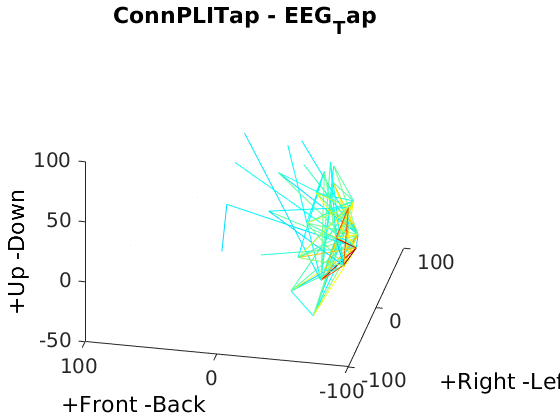

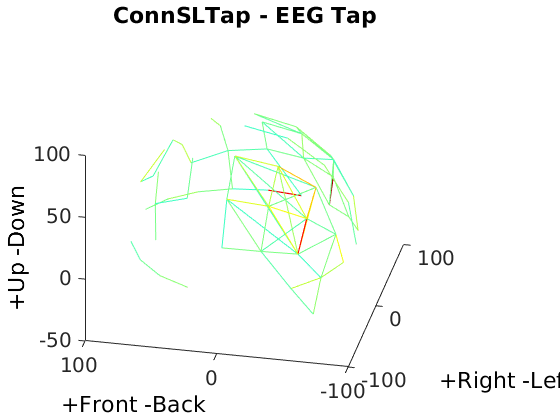

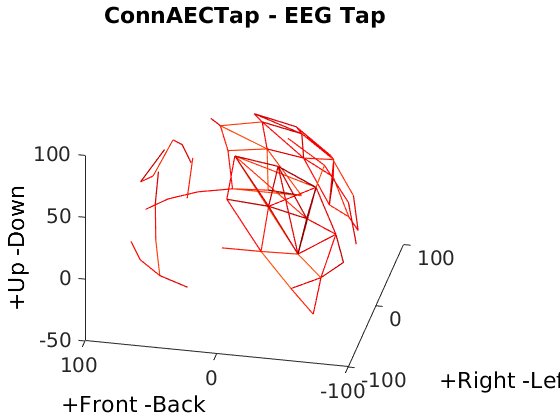

In [99]:
%plot inline
cDotScale = 2;
figure; title('ConnAECTap - EEG Tap');
PlotConnectivity_alt(ConnAECTap,EEG_Tap,95, cDotScale, 1, [0 max(ConnAECTap(:))]);
figure; title('ConnSLTap - EEG Tap');
PlotConnectivity_alt(ConnSLTap,EEG_Tap,95, cDotScale, 1, [0 max(ConnSLTap(:))]);
figure; title('ConnPLITap - EEG_Tap');
PlotConnectivity_alt(ConnPLITap,EEG_Tap,95, cDotScale, 1, [0 max(ConnPLITap(:))]);

For this script, you should pass the EEG struct with it as it will use the electrode positions to plot. You should play a bit with the cDotScale parameter to set the size of the electrode spheres (the red ones). Use the rotation button:

to rotate the image to look from all sides. Alternatively, you can use the “view” command to change the view angle and elevation. NOTE: the green electrode is the OZ (most posterior) electrode, as an anchor for you to orientate.

__Q: Try to explain what you can see in these 3D plots:__

- What is the average connectivity for a node, and how is this represented in the plot?
- How can you tell the strength of connectivity between each pair of nodes?
- Are all connections plotted?
- Can you see clusters of densely interconnected nodes? Which are they for SyncLL and PLI. Does the AEC network resemble more the PLI or the SyncLL network?
- Is there evidence for volume conduction using AEC and SyncLL? Does PLI show a different network activity than the other 2 measures? How can you tell?

...

Concluding, SyncLL and Coherence may have a massive volume conduction problem with 128 channel EEG setups. 
PLI correctly identifies the right temporal areas connected with right motor areas in finger tapping, which is known from the literature to be an important network in rhythmic movement.

As an alternative to plotting 3D graphs, you also often see 2D figures

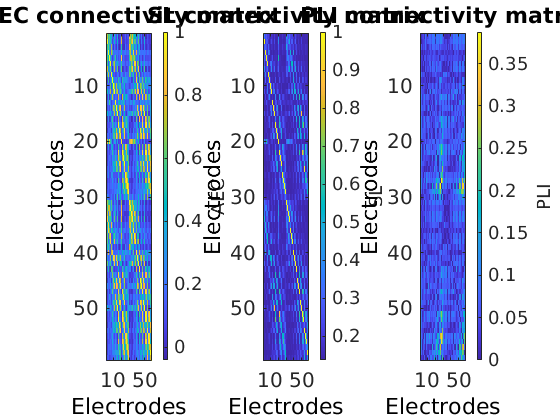

In [77]:
figure;
subplot(1,3,1);
imagesc(ConnAECTap); title('AEC connectivity matrix'); ylabel('Electrodes'); xlabel('Electrodes'); set(get(colorbar,'ylabel'),'string','AEC');
subplot(1,3,2);
imagesc((ConnSLTap).^1); title('SL connectivity matrix'); ylabel('Electrodes'); xlabel('Electrodes'); set(get(colorbar,'ylabel'),'string','SL');
subplot(1,3,3);
imagesc(ConnPLITap); title('PLI connectivity matrix'); ylabel('Electrodes'); xlabel('Electrodes'); set(get(colorbar,'ylabel'),'string','PLI');

These plots show the connectivity matrices of all possible pairs of electrodes. The x-axis are all 128 labels, the y-axis also all 128 electrodes, the colors represent the strength of the connection. To assess whether PLI, SyncLL and AEC create similar or different connectivity networks, you need to compare the pattern of colors across the three plots.


__Q:  How do the networks that you obtain differ? Can you (again) see evidence for volume conduction effects?__

...

### Comparing Eyes open and Tapping networks

Next, we will compare the networks between the EO and tapping conditions. We will use PLI. For this, we need to get the EO connectivity.

In [78]:
ConnPLIEO = PLI(EEG_EO.data(:,:)')


ConnPLIEO =

  Columns 1 through 7

         0    0.0009    0.0235    0.0000    0.0385    0.0029    0.0135
    0.0009         0    0.0247    0.0099    0.0662    0.0303    0.0435
    0.0235    0.0247         0    0.0025    0.0524    0.0332    0.0008
    0.0000    0.0099    0.0025         0    0.0344    0.0112    0.0440
    0.0385    0.0662    0.0524    0.0344         0    0.0649    0.0916
    0.0029    0.0303    0.0332    0.0112    0.0649         0    0.0446
    0.0135    0.0435    0.0008    0.0440    0.0916    0.0446         0
    0.0642    0.0514    0.0809    0.0607    0.0660    0.0289    0.0100
    0.0370    0.0288    0.0541    0.0426    0.0479    0.0215    0.0017
    0.0123    0.0298    0.0134    0.0106    0.0346    0.0601    0.0167
    0.0242    0.0298    0.0076    0.0466    0.0874    0.0992    0.0096
    0.0686    0.0747    0.0860    0.0854    0.0901    0.0681    0.0369
    0.0700    0.0980    0.0498    0.0515    0.0636    0.0858    0.0968
    0.0367    0.0796    0.0113    0.0389

    0.0076    0.0728    0.0800    0.1415    0.1127    0.0665    0.0581
    0.0453    0.0098    0.1324    0.0408    0.0013    0.0795    0.0495
    0.0717    0.0308    0.0067    0.0004    0.0234    0.0749    0.0357
    0.1023    0.0114    0.0193    0.0688    0.0475    0.0616    0.0050
         0    0.0594    0.0702    0.1438    0.1393    0.0508    0.0527
    0.0594         0    0.1001    0.0359    0.0072    0.0716    0.0772
    0.0702    0.1001         0    0.0148    0.0192    0.0670    0.0883
    0.1438    0.0359    0.0148         0    0.1142    0.0795    0.0401
    0.1393    0.0072    0.0192    0.1142         0    0.0717    0.0077
    0.0508    0.0716    0.0670    0.0795    0.0717         0    0.0512
    0.0527    0.0772    0.0883    0.0401    0.0077    0.0512         0
    0.0681    0.1006    0.0055    0.0036    0.0279    0.0618    0.1138
    0.1006    0.0763    0.0306    0.0046    0.0389    0.0572    0.0674
    0.1420    0.0279    0.0029    0.0477    0.0846    0.0777    0.0310
    0.

    0.0138    0.0524    0.0804    0.0837    0.0326    0.0291    0.0684
    0.0145    0.0235    0.0560    0.0438    0.0231    0.0130    0.0266
    0.0182    0.0109    0.0039    0.0184    0.0439    0.0218    0.0008
    0.0548    0.0146    0.0024    0.0483    0.0713    0.0121    0.0216
    0.0223    0.0402    0.0833    0.0906    0.0716    0.0555    0.0921
    0.0364    0.0314    0.0764    0.0591    0.0871    0.0932    0.0601
    0.0639    0.0634    0.0227    0.0521    0.0836    0.0665    0.0358
    0.0442    0.0081    0.0030    0.0463    0.0388    0.0115    0.0259
    0.0102    0.0329    0.0662    0.0760    0.0692    0.0507    0.0730
    0.0699    0.0505    0.0596    0.0758    0.0817    0.0704    0.0761
    0.1075    0.0987    0.0474    0.0644    0.1151    0.1053    0.0523
    0.0809    0.0932    0.0279    0.0582    0.0940    0.0730    0.0448
    0.0454    0.0014    0.0404    0.0152    0.0343    0.0542    0.0414
    0.0139    0.0385    0.0292    0.0410    0.0611    0.0538    0.0247
    0.

    0.0829    0.0762    0.0465    0.0566    0.0834    0.0503    0.0558
    0.0888    0.0836    0.0584    0.0797    0.0722    0.0446    0.0740
    0.0671    0.0786    0.1203    0.0981    0.0762    0.0982    0.1265
    0.0439    0.0485    0.1001    0.0561    0.0441    0.0969    0.1053
    0.0338    0.0712    0.0264    0.0108    0.0769    0.0619    0.0217
    0.0038    0.0891    0.0180    0.0057    0.0786    0.0582    0.0102
    0.0373    0.0327    0.0839    0.0221    0.0453    0.0567    0.0803
    0.0610    0.0590    0.1267    0.1129    0.0705    0.1024    0.1354
    0.0885    0.0713    0.0300    0.0217    0.1518    0.0677    0.0155
    0.0545    0.0348    0.0054    0.0438    0.0212    0.0315    0.0060
    0.0007    0.0098    0.0432    0.1157    0.0156    0.0286    0.0921
    0.0534    0.0402    0.1078    0.1000    0.0540    0.0892    0.1391
    0.0811    0.0383    0.0128    0.0330    0.1055    0.0625    0.0169
    0.1260    0.1166    0.0024    0.0447    0.0770    0.0264    0.0013
    0.

    0.0921    0.0909    0.0536
    0.0281    0.0151    0.0070
    0.0221    0.0347    0.0395
    0.0498    0.0502    0.0532
    0.1034    0.1089    0.0657
    0.0915    0.0902    0.0410
    0.0393    0.0151    0.0088
    0.0073    0.0034    0.0076
    0.0591    0.0530    0.0074
    0.0979    0.1049    0.0495
    0.0232    0.0111    0.0100
    0.0058    0.0039    0.0347
    0.0118    0.0034    0.0742
    0.0899    0.1041    0.0390
    0.0363    0.0219    0.0097
    0.0371    0.0314    0.0416
    0.0314    0.0749    0.1164
    0.0110    0.0030    0.0937
    0.0675    0.0581    0.0439
    0.0394    0.0102    0.0064
    0.0404    0.0395    0.0365
    0.0910    0.0608    0.0674
    0.0256    0.0839    0.1225
    0.0142    0.0253    0.1141
    0.0420    0.0079    0.0119
    0.0094    0.0117    0.0134
    0.1156    0.0541    0.0026
    0.0851    0.1172    0.0346
    0.0598    0.0618    0.0404
    0.0308    0.0285    0.0065
    0.0434    0.0342    0.0311
    0.0938    0.0957    0.0528
    0.08

__Q: Plot the network using PlotConnectivity_alt.m. Can you spot obvious differences?__

...

An alternative way to plot connectivity matrices is by using images, another often-used plotting technique.


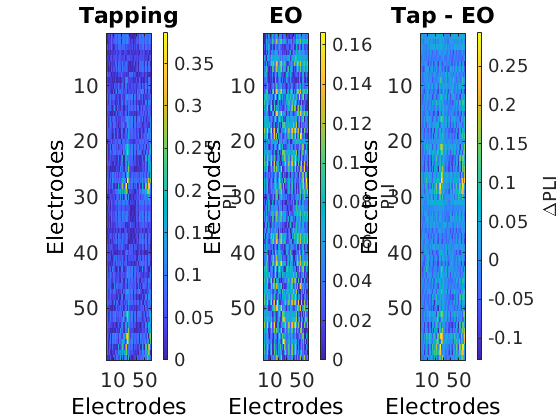

In [80]:
figure;
subplot(1,3,1);
imagesc(ConnPLITap); title('Tapping'); ylabel('Electrodes'); xlabel('Electrodes'); set(get(colorbar,'ylabel'),'string','PLI');
subplot(1,3,2);
imagesc(ConnPLIEO); title('EO'); ylabel('Electrodes'); xlabel('Electrodes'); set(get(colorbar,'ylabel'),'string','PLI');
subplot(1,3,3);
imagesc(ConnPLITap-ConnPLIEO); title('Tap - EO'); ylabel('Electrodes'); xlabel('Electrodes'); set(get(colorbar,'ylabel'),'string','{\Delta}PLI');

__Q: What is plotted here. How can you spot densely connected clusters in this type of plot?__

---

### Source level connectivity

In this part, we wish to investigate whether Independent Components Analysis has produce ICs that are related to the tapping. We wish to investigate additionally whether the we can establish communication between the source signals (aka activations).

We can identify tapping-related induced activity using the time-frequency transformed data. Induced activity is any SYSTEMATIC effect of an event on oscillations. This effect can be either of phase or amplitude, but here we will focus solely on INDUCED AMPLITUDE EFFECTS. 

We will epoch the data file (i.e.,split the continuous data into chunks with a fixed relation to a finger tap event). First reload the unfiltered tapping data: `EEG_Tap  = pop_loadset('TappingContinuous.set')`

Next create the epochs. We will try to identify two sources that may be relevant to tapping

In [83]:
EEG_TapEpoch = pop_epoch(EEG_Tap, {'1'}, [-1.4   1.4], 'newname', 'BDF file resampled pruned with ICA epochs', 'epochinfo', 'yes');

Error using pop_epoch (line 235)
pop_epoch(): empty epoch range (no epochs were found).



__Q: How long is the epoch in milliseconds?__

...

ICA has been run for you. Can you interpret what the components are? We’ll use the following command to plot the 15 most important components and view their loading topographies. If you click the buttons, you can get more information like the IC power spectrum and time course.

In [84]:
% INSPECT THE COMPONENTS. Which are over motor cortices and possibly
% involved in steering the finger tapping?

pop_selectcomps(EEG, [1:15]);

Drawing figure...


Dot indexing is not supported for variables of this type.

Error in pop_selectcomps (line 79)
if isempty(EEG.reject.gcompreject)



__Q: What are components 9, 14, and 1; that is, can you explain what type of source activity they represent based on their topographic loadings and spectra?__

...

Error using eval
Unrecognized function or variable 'EEG_TapEpoch'.



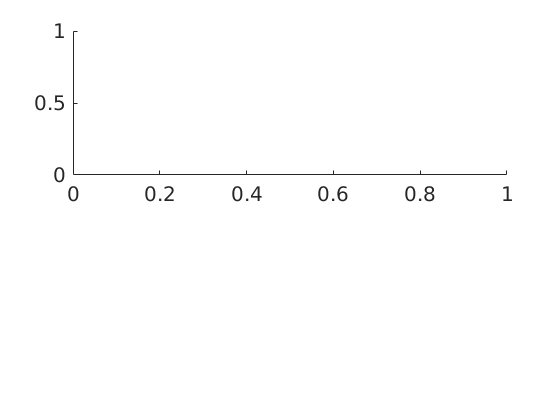

In [85]:
figure; 
subplot(2,1,1)
pop_newtimef(EEG_TapEpoch, 0, 9, [-1398 1391], [2 0.5], 'topovec', EEG.icawinv(:,9), 'elocs', EEG.chanlocs, 'chaninfo', EEG.chaninfo, 'caption', ['IC 9'], 'baseline', [0], 'plotphase', 'off', 'plotitc', 'off', 'padratio', 2);

subplot(2,1,2)
pop_newtimef(EEG_TapEpoch, 0, 14, [-1398 1391], [2 0.5], 'topovec', EEG.icawinv(:,14), 'elocs', EEG.chanlocs, 'chaninfo', EEG.chaninfo, 'caption', ['IC 14'], 'baseline', [0], 'plotphase', 'off', 'plotitc', 'off', 'padratio', 2);

Were interested in high alpha/beta activity only. Extract Independent components in this range. ICs were already computed, filter the data + IC activations (=source signals) within these frequencies.

In [40]:
frqlo = 10;
frqhi = 30;
EEG_TapEpoch = pop_eegfiltnew(EEG_TapEpoch, frqlo, frqhi, []);
Times = EEG_TapEpoch.times;

Error using eval
Unrecognized function or variable 'EEG_TapEpoch'.



### Overall connectivity between components

We will use PLI to get source level connectivity.

In [41]:
ActSL = SyncLL(act([1 9 14],:)','reconstruct',[frqlo frqhi EEG_TapEpoch.srate],'speed',256,'verbose',1);
ActPLI = PLI(act([1 9 14],:)');
ActnCoh = Coherence(act([1 9 14],:)',[frqlo frqhi 13],EEG_TapEpoch.srate,'verbose',1);

Unrecognized function or variable 'act'.



---
---

## (ADVANCED)

### Time-dependent connectivity between components

Unfortunately, the activations are the wrong shape. The data are a 3D array (chnnels by points by epochs) whereas in the activations the points and epochs are concatenated into a single dimension. To correct this:


In [42]:
size(EEG_TapEpoch.data)
act = reshape(act,[70   358   397]);

Unable to resolve the name EEG_TapEpoch.data.



The following script will compute connectivity over selected parts of the component activations relative to the tapping event. If there is a tapping network active during tapping (rather than that there are selected sources active), then I would expect that the ICA sources not just oscillate at 1 Hz in their own activity, but also that the connectivity oscillates with 1 Hz. 1 Hz was namely the tapping frequency.

In the following, I select chunks of data from the data epochs that are at a fixed interval from the tapping event. These chunks are 20 samples wide. I concatenate them over all the epochs. I do this for the signals of the first 14 components.

Then I compare the chunks from components 14 to all others (1:13). Then I plot the evolution of the connectivity between each component and number 14 over time.

Error using eval
Unrecognized function or variable 'act'.



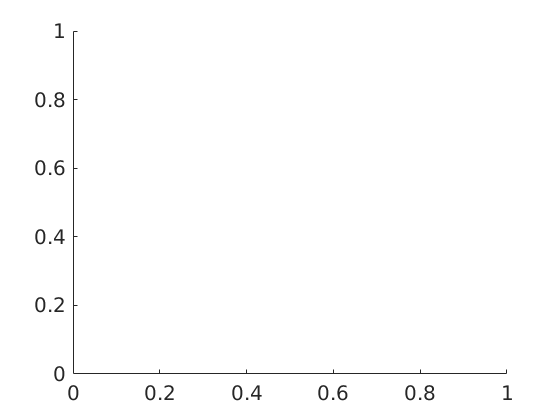

In [43]:
% calculate the change of connectivity over time in 20 sample wide blocks.
% Compare component 14 (right motor) to the 13 before
figure;
hold on;
p=[];              % p will hold the connectivity between comps 1:13 evolving over time
for comp1=1:13;    % componnets to compare with n. 14
    count=0;       % a counter
    for s=1:10:size(act,2)-39,            % this is the time parameter (s=sample) 
        count=count+1;                    % up the counter
        temp = act([comp1 14],s:s+39,:);  % extract the data, use temp(:,:) to concatenate
        % t=SyncLL(temp(:,:)','reconstruct',[frqlo frqhi EEG_TapEpoch.srate],'speed',32); 
        t=Coherence(temp(:,:)',[10 30],EEG_TapEpoch.srate);   
        p(comp1,count)=t(2,1);                % store in the p matrix
    end
    plot(p(comp1,:),'.-','color',rand(3,1));  % use a random color
end
% create a legend
for l=1:13,
    leg{l}=sprintf('%d with 14\n',l); 
end; 
legend(leg)